# Visualize light curves for all the sources of a region and skymaps of its fields 

In [1]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

#Setup region and plotting paramters
region_name = "TDS_ELAISN1"

lc_block_srcs = 5 #Setup light curve plotting parameters
lc_pars = ["rg_src_id","nr_det","mag","flux_cpval","mag_var_ex","flux_rchiq","pos_var_ex"]
sort_par = "rg_src_id" # "mag" #"rg_src_id" #

#Load region
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
tt_srcs = rg.tt_sources[rg.tt_sources["sel"]]
nr_srcs = len(tt_srcs)
tt_srcs.sort(sort_par)
#display(tt_srcs)

### Draw light curves

interactive(children=(IntSlider(value=38, description='block_nr', max=77), Output()), _dom_classes=('widget-in…

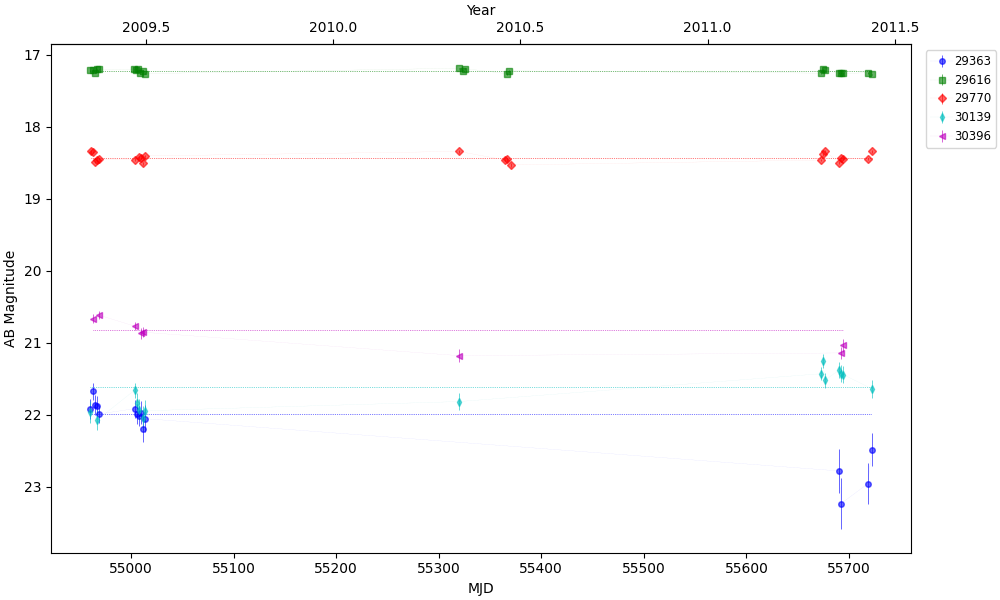

In [2]:
nr_blocks = int(nr_srcs/lc_block_srcs)+1 
fig_lc = plt.figure("Light curves",figsize=(10, 6), constrained_layout=True)
def plot_lc_range(block_nr):
    plt.cla()
    lc_min = lc_block_srcs * block_nr
    lc_max = lc_min + lc_block_srcs if lc_min + lc_block_srcs<=nr_srcs-1 else nr_srcs-1
    vvis.plot_light_curve(rg,fig=fig_lc, rg_src_ids = tt_srcs["rg_src_id"][lc_min:lc_max]) #, ylim = [25,15]
    display(tt_srcs[lc_min:lc_max][lc_pars])
widgets.interactive( plot_lc_range, block_nr=(0,nr_blocks-1))